# **4. Revenue Simulation and Optimal Pricing Strategy**

## **4.1 Motivation**

Price elasticity tells us how sensitive demand is to price changes, but it does not directly tell us:

- whether revenue increases or decreases after a price change  

- how much price should be raised or lowered

- which zones are “safe” for price increases  

Revenue is what ultimately matters for the platform and drivers, and since elasticity varies significantly across zones and hours,  
we simulate price scenarios for each zone–hour to find the revenue-maximizing price.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import tabulate
from scipy.interpolate import make_interp_spline

df = pd.read_parquet("price_elasticity_master.parquet")
df.head()

,PULocationID,pickup_hour,avg_price,trip_count,trip_miles,elasticity_high,elasticity_low,demand_level,journey_type,location_type,peak_offpeak,peak_offpeak_elasticity
0,176,23,5.372758,305.142857,6.859947,1.138958,NaN,Low,Short,Non-Manhattan,Off-Peak,1.138958
1,244,5,4.982080,5020.000000,7.462618,NaN,NaN,Low,Short,Manhattan,Off-Peak,NaN
2,22,13,7.108104,5581.571429,3.952803,NaN,NaN,Medium,Medium,Non-Manhattan,Medium,NaN
3,42,15,7.753044,14414.142857,3.997547,NaN,-2.852036,Medium,Medium,Manhattan,Medium,NaN
4,112,23,6.484931,18593.857143,4.429369,4.877441,NaN,High,Long,Non-Manhattan,Peak,4.877441


In [15]:
df.isna().mean().sort_values(ascending=False)

elasticity_high            0.717527
peak_offpeak_elasticity    0.717527
elasticity_low             0.630772
PULocationID               0.000000
pickup_hour                0.000000
avg_price                  0.000000
trip_count                 0.000000
trip_miles                 0.000000
demand_level               0.000000
journey_type               0.000000
location_type              0.000000
peak_offpeak               0.000000
dtype: float64

### Load Step 3 Aggregated Data

In [16]:
df_sim = df.copy()
df_sim.head()

,PULocationID,pickup_hour,avg_price,trip_count,trip_miles,elasticity_high,elasticity_low,demand_level,journey_type,location_type,peak_offpeak,peak_offpeak_elasticity
0,176,23,5.372758,305.142857,6.859947,1.138958,NaN,Low,Short,Non-Manhattan,Off-Peak,1.138958
1,244,5,4.982080,5020.000000,7.462618,NaN,NaN,Low,Short,Manhattan,Off-Peak,NaN
2,22,13,7.108104,5581.571429,3.952803,NaN,NaN,Medium,Medium,Non-Manhattan,Medium,NaN
3,42,15,7.753044,14414.142857,3.997547,NaN,-2.852036,Medium,Medium,Manhattan,Medium,NaN
4,112,23,6.484931,18593.857143,4.429369,4.877441,NaN,High,Long,Non-Manhattan,Peak,4.877441


## **4.2 Handle Missing Elasticity Values**

To address missing elasticity estimates in several zone–hour rows, we apply a structured imputation strategy based on operational characteristics:

1) **Define grouping dimensions**
   We group the data by four behavioral attributes:
   - `location_type`  
   - `journey_type`  
   - `demand_level`  
   - `peak_offpeak`

   Since zone-hours with similar trip context tend to exhibit similar elasticity, this grouping allows us to compute representative median elasticities for each behavioral segment and use them to fill missing values in a structured, context-aware way.

2) **Compute group-level medians**
   For each combination of these attributes, we calculate the median elasticity within that group.

3) **Impute missing values using group medians**  
   For rows where elasticity is missing, we replace it with the median elasticity of its corresponding group.

4) **Drop rows that still cannot be imputed**
   If a row belongs to a group that has no valid elasticity at all, it remains missing and is safely removed.

---

This approach ensures that:

- Elasticity estimates remain **realistic and consistent** with similar zone-hour behaviors.  
- We avoid introducing random noise or biased assumptions.  
- The resulting data (`elasticity_used`) is **complete**, enabling simulation for all remaining zone-hours.

---

**Note**: 

In our analysis, we use the Medium to High elasticity (`elasticity_high`) as the primary elasticity measure, as it reflects rider behavior under price increases and is therefore directly relevant to evaluating upward pricing adjustments.

Why elasticity_high and elasticity_low Are Different?

- `elasticity_high` = reaction to price increases (loss, necessity, surge). 
   
   High prices occur in “essential trip” situations, such as Peak hours, bad weather, airport trips, for which riders often cannot avoid traveling, so demand remains high even with higher prices.
- `elasticity_low` = reaction to discounts (optional behavior, promotion).
   
   Low prices occur when demand is already low, for example, discounts appear in low-demand hours or residential areas → **lowering price does not generate large new demand**.

These behaviors are fundamentally different, the two elasticities naturally differ in size.



In [17]:
group_cols = ["location_type", "journey_type", "demand_level", "peak_offpeak"]
ELASTICITY_COL = "elasticity_high"  # use elasticity_high for price increases

# Compute group medians
group_medians = df_sim.groupby(group_cols)[ELASTICITY_COL].median()

# Fill missing elasticity
def fill_elasticity(row):
    if pd.notna(row[ELASTICITY_COL]):
        return row[ELASTICITY_COL]
    key = tuple(row[col] for col in group_cols)
    return group_medians.get(key, np.nan)

df_sim["elasticity_used"] = df_sim.apply(fill_elasticity, axis=1)

# Remove rows still NaN
df_sim = df_sim[df_sim["elasticity_used"].notna()].reset_index(drop=True)

print("Usable rows:", len(df_sim))

Usable rows: 6259


## **4.3 Revenue Simulation Function**

We implement all simulation logic inside:

`simulate_revenue(row)`

Inputs include:

- `avg_price`
- `trip_count`
- `trip_miles`
- `elasticity_used`

The function:

1. Iterates through price changes from −10% to +15%
2. Computes new prices  
3. Predicts new demand using elasticity  
4. Computes revenue = price × demand × miles  
5. Returns:
   - `optimal_price_change`
   - `old_revenue`
   - `max_revenue`
   - `revenue_gain`

This function converts elasticity data into actionable pricing recommendations.


### 4.3.1 Define Simulation Parameters

We define a safe simulation range of price adjustments, from −10% to +15%, and specify that the demand response should be based on the `elasticity_high` estimate, which captures how demand changes when prices change.

In [18]:
PRICE_SCAN = np.linspace(-0.10, 0.15, 21)   # safe simulation range

### 4.3.2 Define Stimulation Function

The `simulate_revenue()` function constructs a revenue curve for each zone-hour by scanning price adjustments from −10% to +15%.
Using the zone-hour elasticity, it predicts the resulting demand, computes revenue for each scenario, and identifies the optimal price change that maximizes revenue.

In [19]:
def simulate_revenue(row):
    """
    Simulate revenue outcomes for a single zone-hour across a range of price changes.

    Args:
        row (pandas.Series): A zone-hour record containing the fields
            - avg_price (float): Baseline price per mile.
            - trip_count (float): Baseline demand.
            - trip_miles (float): Average trip length.
            - elasticity_used (float): Estimated price elasticity.

    Returns:
        pandas.Series: A series containing:
            - optimal_price_change (float): Price adjustment (from PRICE_SCAN)
                that yields the highest simulated revenue.
            - old_revenue (float): Revenue at baseline price and baseline demand.
            - max_revenue (float): Maximum achievable revenue under the simulation grid.
            - revenue_gain (float): Percentage gain relative to the baseline revenue.
    """
    elasticity = row["elasticity_used"]
    base_price = row["avg_price"]
    base_demand = row["trip_count"]
    miles = row["trip_miles"]
    
    # Simulated price changes
    price_changes = PRICE_SCAN

    # New prices
    new_prices = base_price * (1 + price_changes)

    # New demand based on elasticity
    new_demand = base_demand * (1 + elasticity * price_changes)
    new_demand = np.maximum(new_demand, 0)     # demand cannot be negative

    # Revenue
    revenue = new_prices * new_demand * miles

    # Return summary
    return pd.Series({
        "optimal_price_change": price_changes[np.argmax(revenue)],
        "old_revenue": base_price * base_demand * miles,
        "max_revenue": np.max(revenue),
        "revenue_gain": np.max(revenue) / (base_price * base_demand * miles) - 1
    })


### 4.3.3 Apply Simulation Across All Zone–Hours

We run the simulation for all usable zone-hour entries.

Output produced:

- For each row:
  - optimal price adjustment  
  - maximum achievable revenue  
  - percentage revenue gain  
  - baseline revenue for comparison  

This gives us a fully simulated pricing surface across all NYC zones.

In [20]:
sim_results = df_sim.apply(simulate_revenue, axis=1)

df_sim = pd.concat([df_sim, sim_results], axis=1)

## **4.4 Final Output Table**

In this step, we collect all relevant simulation outputs and metadata into a clean, well-structured summary table (final_df) that ranks zone–hours by revenue improvement.

Also,this table is final analytical product.

### 4.4.1 Assign Price Sensitivity Labels

We converts each zone-hour’s elasticity value into a human-interpretable price sensitivity category.

Since elasticity is a continuous number, this step buckets it into three meaningful behavioral labels:
- Highly Elastic for e <= -1.5
- Moderately Elastic for -1.5 < e <= -0.8
- Inelastic for e > -0.8

In [21]:
def label_sensitivity(e):
    """
    Assign a price sensitivity category based on elasticity.

    Args:
        e (float): The elasticity value for a zone-hour.

    Returns:
        str: One of three labels indicating demand responsiveness:
            - "Highly Elastic" for e <= -1.5
            - "Moderately Elastic" for -1.5 < e <= -0.8
            - "Inelastic" for e > -0.8
    """
    if e <= -1.5:
        return "Highly Elastic"
    elif e <= -0.8:
        return "Moderately Elastic"
    else:
        return "Inelastic"

df_sim["price_sensitivity"] = df_sim["elasticity_used"].apply(label_sensitivity)


### **4.4.2 Final Output Table**

In [22]:
final_df = df_sim[[
    "PULocationID", "pickup_hour",
    "avg_price", "trip_count", "trip_miles",
    "elasticity_used", "demand_level", "journey_type",
    "location_type", "peak_offpeak",
    "optimal_price_change", "revenue_gain",
    "price_sensitivity"
]].sort_values("revenue_gain", ascending=False)

final_df.head()

,PULocationID,pickup_hour,avg_price,trip_count,trip_miles,elasticity_used,demand_level,journey_type,location_type,peak_offpeak,optimal_price_change,revenue_gain,price_sensitivity
1469,158,3,6.720518,2979.857143,6.501286,45.432912,Low,Long,Manhattan,Off-Peak,0.15,7.987177,Inelastic
5614,34,4,6.420076,1407.571429,7.358343,41.966437,Medium,Medium,Non-Manhattan,Medium,0.15,7.389210,Inelastic
3844,34,5,6.330577,1147.571429,7.250365,33.741861,Medium,Medium,Non-Manhattan,Medium,0.15,5.970471,Inelastic
6051,34,3,6.391382,1332.142857,6.632527,32.990252,Medium,Medium,Non-Manhattan,Medium,0.15,5.840818,Inelastic
918,211,3,7.255137,2793.285714,6.262525,27.767230,Low,Medium,Manhattan,Off-Peak,0.15,4.939847,Inelastic


## **4.5 Results Visualization**

### **4.5.1 Summary of Sensitivity Category Distribution**

The pie chart shows that the vast majority of zone-hours fall into the inelastic category (94.6%), indicating that demand typically changes very little when prices rise. Approximately 3.2% of zone-hours are classified as Highly Elastic, and 2.2% fall into the Moderately Elastic range.

This distribution highlights that most areas and time periods in NYC are price-insensitive, which explains why upward price adjustments often do not lead to large drops in demand. Elastic behavior is relatively rare and concentrated in specific behavioral or contextual segments.

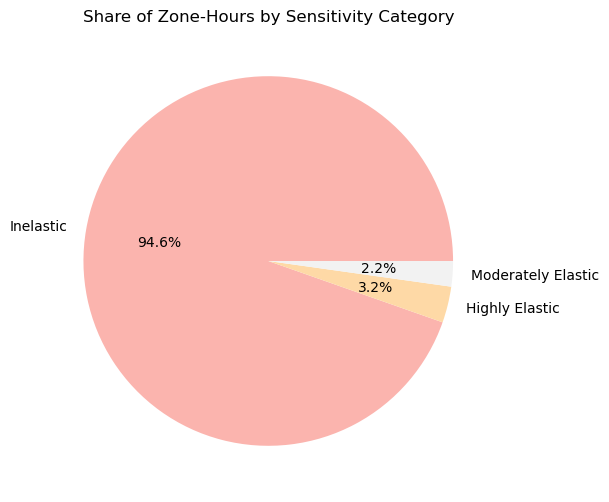

In [23]:
df_sim["price_sensitivity"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(6, 6), colormap="Pastel1"
)

plt.title("Share of Zone-Hours by Sensitivity Category")
plt.ylabel("")
plt.show()

### **4.5.2 NYC Taxi Zones — Average Revenue Gain After Optimal Price Adjustment**

The map visualizes the average revenue gain (%) for each NYC taxi zone after applying the zone-specific optimal price change.  

#### Key Observations:
- **Manhattan core and airport-adjacent zones** display the largest revenue gains (lighter green).  
  These areas have strong trip demand and low price sensitivity, so modest price increases generate noticeable revenue growth.

- **Most residential zones in Brooklyn, Queens, the Bronx, and Staten Island** show more modest gains (yellow–red tones), reflecting higher price sensitivity and limited upside from price adjustments.

- Grey areas (if any) indicate zones without sufficient data for reliable elasticity estimation.



<Figure size 1200x1200 with 0 Axes>

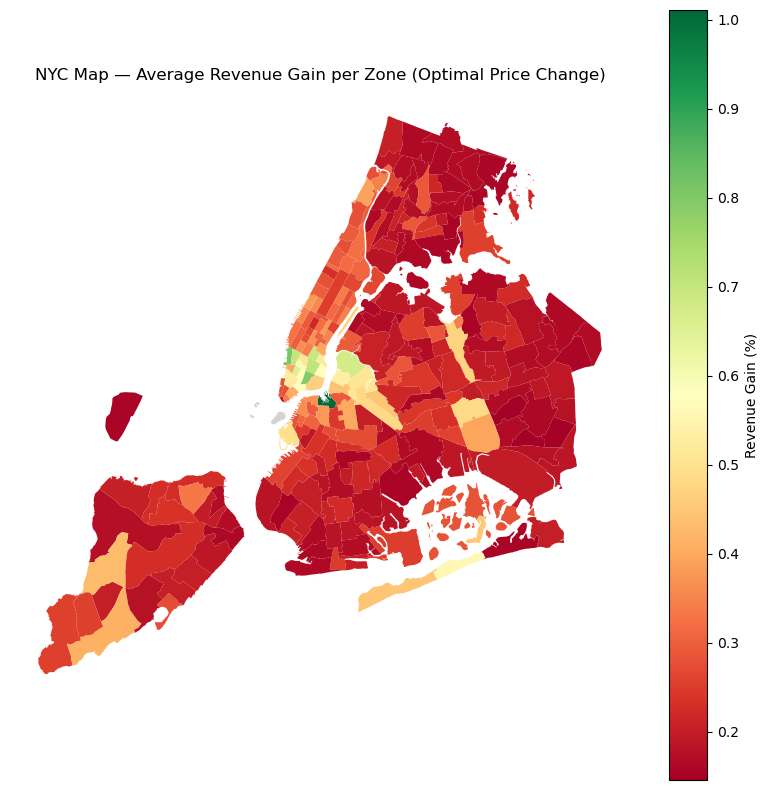

In [24]:
zones = gpd.read_file("/Users/royanbear/Desktop/DS-GA 1007/final project/taxi_zones_shapefile/taxi_zones.shp")
zone_gain = final_df.groupby("PULocationID")["revenue_gain"].mean().reset_index()

zones_merged = zones.merge(
    zone_gain,
    left_on="LocationID",
    right_on="PULocationID",
    how="left"
)

plt.figure(figsize=(12, 12))
zones_merged.plot(
    column="revenue_gain",
    cmap="RdYlGn",
    legend=True,
    legend_kwds={'label': "Revenue Gain (%)"},
    missing_kwds={"color": "lightgrey"},
    figsize=(10, 10)
)
plt.title("NYC Map — Average Revenue Gain per Zone (Optimal Price Change)")
plt.axis("off")
plt.show()

### **4.5.3 Revenue Gain (%) by Zone and Hour Heatmap**

The heatmap visualizes how the **average revenue gain (%)** varies across  
NYC pickup zones and hours of the day, after applying each zone-hour’s optimal price adjustment.  

#### Key Observations:
- Most cells show **light yellow colors**, indicating that the expected revenue increase is generally small (typically below 1%).  
  This aligns with earlier findings that most zone-hours are **inelastic**, so price changes have limited impact on revenue.

- A limited number of **dark green streaks** appear for specific zones and hours.  
  These correspond to **high-demand or surge-like contexts**, where optimal price increases yield noticeably higher revenue gains.

- The pattern is highly heterogeneous across both dimensions:  
  **different zones respond differently at different hours**, emphasizing that pricing opportunities are highly localized and time-dependent.


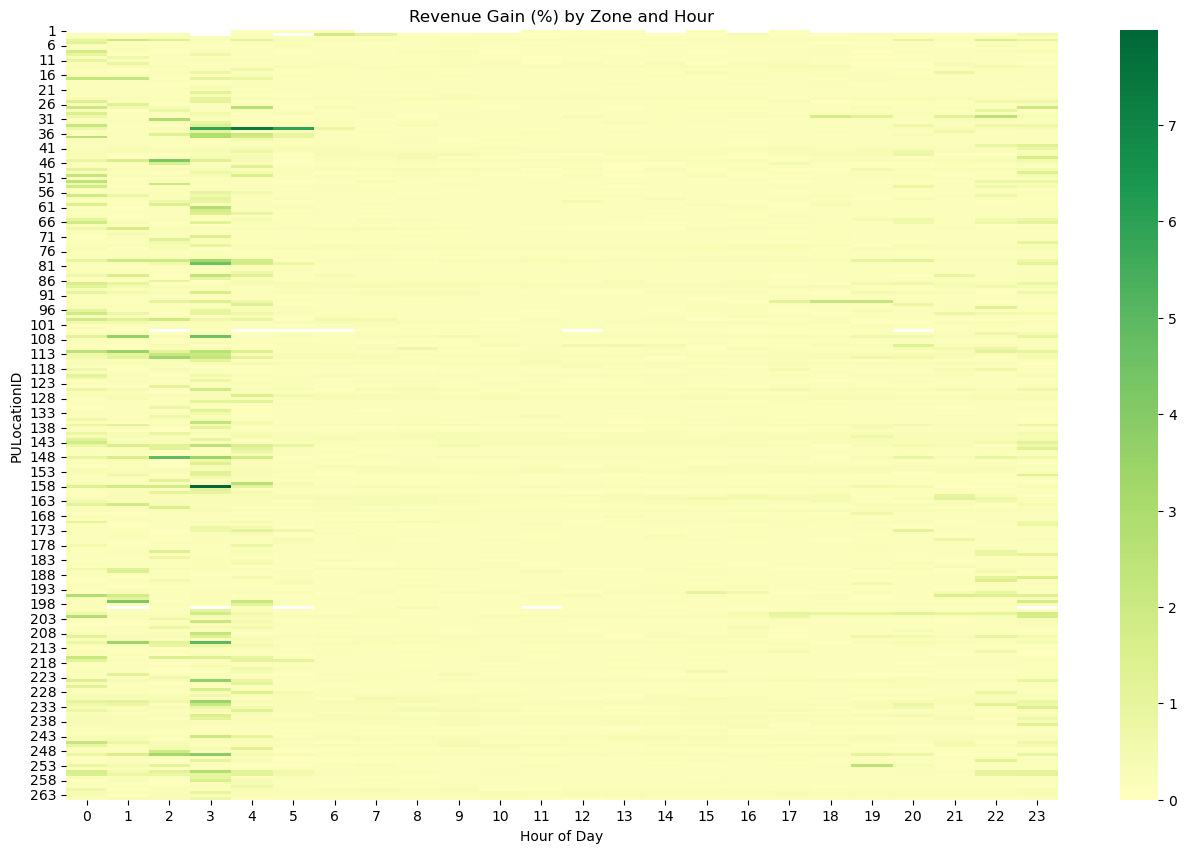

In [25]:
heatmap_df = final_df.pivot_table(
    index="PULocationID",
    columns="pickup_hour",
    values="revenue_gain"
)

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_df, cmap="RdYlGn", center=0)
plt.title("Revenue Gain (%) by Zone and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("PULocationID")
plt.show()


### **4.5.4 Revenue Curves and Price Responses**

We identify three key zone–hour cases based on their revenue behavior under simulated price adjustments, and visualizes each case with a smooth revenue curve:

- Best Price Increase Case:
Selects the zone-hour with the highest revenue gain when applying the optimal price increase.
Represents inelastic demand, where increasing price raises revenue.

- Best Price Decrease Case:
Identifies zone-hours where the optimal price change equals the minimum tested value (−10%).
Represents highly elastic demand, where lowering price improves revenue.

- Moderate Elasticity Case:
Selects a zone-hour with moderate elasticity.

These three representative plots illustrate how different elasticity profiles lead to different optimal pricing strategies across NYC taxi zones and hours.


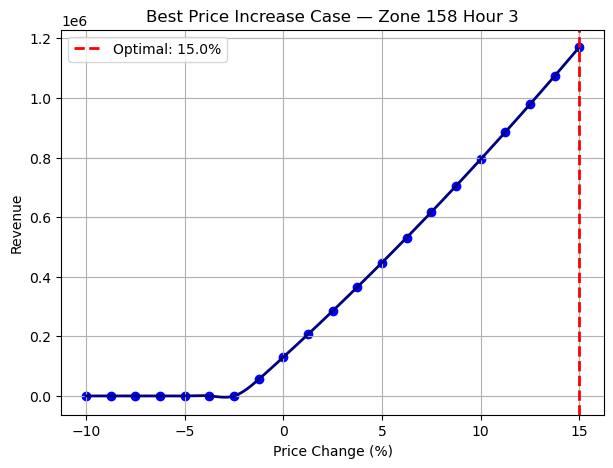

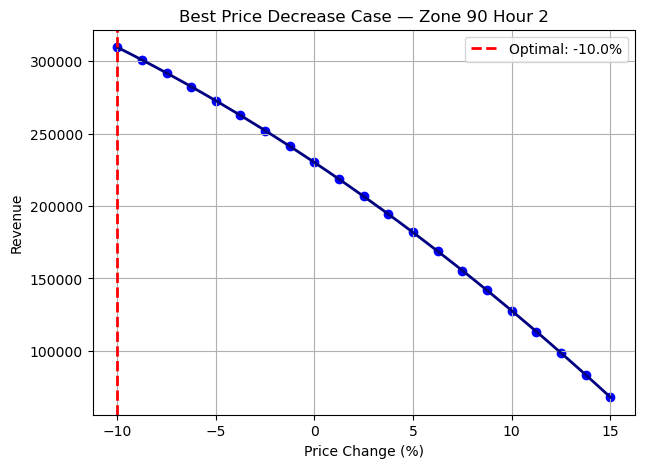

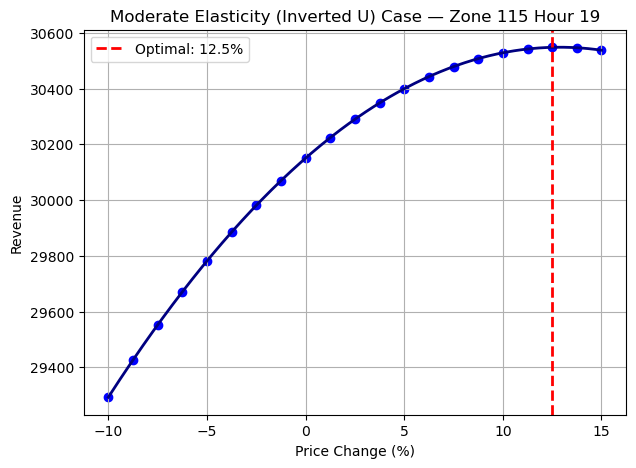

In [ ]:
# Ensure PRICE_SCAN exists
if 'PRICE_SCAN' not in globals():
    PRICE_SCAN = np.linspace(-0.10, 0.15, 21)

# Smooth Revenue Curve Plot Function
def plot_revenue_curve_smooth(row_index, title_prefix="Revenue Curve"):
    """
    Plot a smooth revenue curve for a selected zone-hour based on simulated
    price adjustments and elasticity.

    This function takes a zone-hour record from df_sim, simulates revenue
    under a range of price changes (PRICE_SCAN), smooths the resulting revenue
    curve using spline interpolation, and visualizes:
        - the relationship between price changes (%) and revenue, and
        - the optimal price adjustment that maximizes revenue.

    Args:
        row_index (int): Index of the target row in df_sim to visualize.
        title_prefix (str): Optional title prefix for the plot.

    Returns:
        None: Displays a matplotlib figure showing:
            - the smoothed revenue curve,
            - discrete revenue points,
            - and a vertical line indicating the optimal price change.
    """
    row = df_sim.iloc[row_index]

    elasticity = row["elasticity_used"]
    base_price = row["avg_price"]
    base_demand = row["trip_count"]
    miles = row["trip_miles"]

    price_changes = PRICE_SCAN
    new_prices = base_price * (1 + price_changes)
    new_demand = base_demand * (1 + elasticity * price_changes)
    new_demand = np.maximum(new_demand, 0)

    revenue = new_prices * new_demand * miles

    # Smooth curve
    x_smooth = np.linspace(price_changes.min()*100, price_changes.max()*100, 300)
    spline = make_interp_spline(price_changes*100, revenue)
    y_smooth = spline(x_smooth)

    plt.figure(figsize=(7, 5))
    plt.plot(x_smooth, y_smooth, color="navy", linewidth=2)
    plt.scatter(price_changes*100, revenue, color="blue")

    opt_pc = row["optimal_price_change"] * 100
    plt.axvline(opt_pc, color="red", linestyle="--", linewidth=2,
                label=f"Optimal: {opt_pc:.1f}%")

    plt.title(f"{title_prefix} — Zone {row['PULocationID']} Hour {row['pickup_hour']}")
    plt.xlabel("Price Change (%)")
    plt.ylabel("Revenue")
    plt.grid(True)
    plt.legend()
    plt.show()


# Identify three representative cases
idx_raise = df_sim["revenue_gain"].idxmax() # Best Price Increase Case

drop_candidates = df_sim[df_sim["optimal_price_change"] == PRICE_SCAN.min()] # Best Price Decrease Case

if len(drop_candidates) > 0:
    idx_drop = drop_candidates.index[0]
else:
    print("No zone-hour qualifies as 'best price decrease'. Using most elastic area.")
    idx_drop = df_sim["elasticity_used"].idxmin()


# Moderate Elasticity
moderate_df = df_sim[
    (df_sim["optimal_price_change"] > PRICE_SCAN.min()) &
    (df_sim["optimal_price_change"] < PRICE_SCAN.max()) &
    (df_sim["elasticity_used"] < -0.2) &
    (df_sim["elasticity_used"] > -0.8)
]

if len(moderate_df) == 0:
    print("No perfect moderate elasticity case found. Trying relaxed filter...")
    moderate_df = df_sim[
        (df_sim["optimal_price_change"] > PRICE_SCAN.min()) &
        (df_sim["optimal_price_change"] < PRICE_SCAN.max())
    ]

if len(moderate_df) == 0:
    print("Still no moderate cases. Using median elasticity row instead.")
    idx_mid = (df_sim["elasticity_used"] - df_sim["elasticity_used"].median()).abs().idxmin()
else:
    idx_mid = moderate_df.index[0]




# Plot the three curves
plot_revenue_curve_smooth(idx_raise, "Best Price Increase Case")
plot_revenue_curve_smooth(idx_drop, "Best Price Decrease Case")
plot_revenue_curve_smooth(idx_mid, "Moderate Elasticity (Inverted U) Case")


In [37]:
top_zone_hours = final_df.head(20)

print(tabulate.tabulate(
    top_zone_hours[[
        "PULocationID", "pickup_hour", "revenue_gain", "optimal_price_change"
    ]],
    headers="keys",
    tablefmt="github"
))

|      |   PULocationID |   pickup_hour |   revenue_gain |   optimal_price_change |
|------|----------------|---------------|----------------|------------------------|
| 1469 |            158 |             3 |        7.98718 |                   0.15 |
| 5614 |             34 |             4 |        7.38921 |                   0.15 |
| 3844 |             34 |             5 |        5.97047 |                   0.15 |
| 6051 |             34 |             3 |        5.84082 |                   0.15 |
|  918 |            211 |             3 |        4.93985 |                   0.15 |
| 4126 |            148 |             2 |        4.82655 |                   0.15 |
| 2758 |             80 |             3 |        4.57338 |                   0.15 |
| 3922 |            107 |             3 |        4.55202 |                   0.15 |
| 4282 |             45 |             2 |        4.18847 |                   0.15 |
| 1484 |            197 |             1 |        4.17824 |                  

#### Conclusion

The three representative revenue curves illustrate distinct behavioral regimes in the price–demand relationship:

- The **Best Price Increase Case** shows a *monotonically increasing* revenue curve.  
  This occurs because the optimal price lies at the **upper boundary** of our scan (+15%), indicating extremely inelastic demand in that zone-hour—revenue keeps rising as price increases.

- The **Best Price Decrease Case** shows a *monotonically decreasing* revenue curve.  
  Here, the optimal value occurs at the **lower boundary** (−10%), meaning that demand drops sharply when price rises, and revenue improves only when price is reduced.

- The **Moderate Elasticity Case** produces a classic **inverted-U curve**, where revenue first increases and then decreases.  
  This represents a balanced regime in which demand responds moderately to price changes, allowing a true interior optimum.

Because NYC yellow cab fares are fixed under TLC regulation, the price scan from −10% to +15% reflects a **hypothetical elasticity experiment**, designed to reveal underlying behavioral patterns rather than propose actionable fare changes.


## **4.5 Final Summary of the Pricing Elasticity and Revenue Optimization Module**

This module develops a full pipeline to understand how NYC taxi demand responds to price changes and how these responses translate into revenue outcomes across space and time. The analysis proceeds in four major steps.

1. **Estimating Elasticity at the Zone-Hour Level**  
   Using Medium, High, and Low price buckets, we compute price elasticity for every zone-hour.  
   The elasticity metrics quantify the percentage change in demand resulting from a percentage change in price, providing a behavioral foundation for downstream simulation. Missing values are imputed using median elasticities within groups defined by location type, journey type, demand level, and peak/off-peak periods.

2. **Classifying Price Sensitivity**  
   Elasticity values are grouped into three human-interpretable categories—Highly Elastic, Moderately Elastic, and Inelastic.  
   A pie chart reveals that the overwhelming majority of zone-hours are **inelastic**, meaning demand remains stable even when prices change. Elastic behavior, while present, is rare and concentrated in specific temporal and spatial contexts.

3. **Optimizing Revenue via Simulated Price Adjustments**  
   For each zone-hour, we simulate revenue under price changes ranging from −10% to +15%, applying the formula:  
   *Revenue = Price × Demand × Trip Miles*.  
   Although NYC yellow cab fares are fixed under TLC regulation, this controlled price scan enables a hypothetical elasticity experiment that reveals how different market conditions would respond to price adjustments.

4. **Visualizing Price–Revenue Relationships and Spatial Patterns**  
   We identify three representative cases:  
   - A **monotonically increasing** revenue curve (best price-increase case), where revenue keeps rising up to the upper boundary → extremely inelastic demand.  
   - A **monotonically decreasing** curve (best price-decrease case), where revenue improves only under price reductions → highly elastic demand.  
   - A **moderate elasticity** case, which forms a clear **inverted-U revenue curve** with an interior optimum → the most theoretically interpretable scenario.  

   Additional heatmaps and choropleth maps highlight strong spatial and temporal heterogeneity, demonstrating that revenue opportunities are highly localized and hour-specific.

---

### **Overall Insight**

Despite regulatory constraints preventing dynamic fare changes, this module provides a behavioral map of NYC taxi demand. The findings show that:
- Most zones exhibit **inelastic behavior**, limiting downside risk from price increases.  
- Some zone-hours are **extremely inelastic**, with revenue rising monotonically through the entire tested range.  
- Others are **highly elastic**, benefiting only from price decreases.  
- A minority exhibit **balanced, economically classical behavior** with true interior optima.

These results form a foundation for understanding demand patterns, evaluating hypothetical pricing scenarios, and informing future modeling work in contexts—such as rideshare platforms—where dynamic pricing is permitted.
